## 0. Import Packages

In [153]:
import input_data
import numpy as np
import matplotlib.pylab as plt

## 1. MNIST Dataset

In [98]:
mnist = input_data.read_data_sets("./samples/MNIST_data/", one_hot = True)

Extracting ./samples/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./samples/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./samples/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./samples/MNIST_data/t10k-labels-idx1-ubyte.gz


In [99]:
print("the number of train examples :" , mnist.train.num_examples)
print("the number of test examples :" , mnist.test.num_examples)

the number of train examples : 55000
the number of test examples : 10000


In [102]:
x_train_orig = mnist.train.images.reshape((55000, 28, 28, 1))
x_test_orig = mnist.test.images.reshape((10000, 28, 28, 1))

In [106]:
# Normalization
x_train = x_train_orig.astype('float32') / 255
x_test = x_test_orig.astype('float32') / 255

y_train = mnist.train.labels
y_test = mnist.test.labels

In [107]:
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(55000, 28, 28, 1)
(10000, 28, 28, 1)
(55000, 10)
(10000, 10)


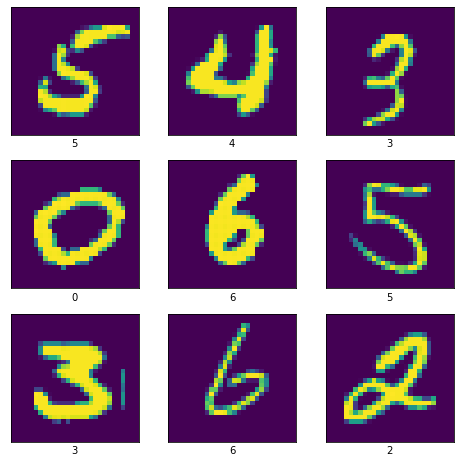

In [109]:
pic,real_values = mnist.train.next_batch(25)  

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = np.reshape(pic[i,:] , [28,28])
    plt.imshow(image)
    plt.xlabel(np.argmax(real_values[i]))
plt.show()

## 2. Convolutional Neural Network

In [146]:
def zero_padding(data, pad):
    padding = np.pad(data,((0,0),(pad,pad),(pad,pad),(0,0)), 'constant')
    
    return padding

In [147]:
def softmax(y_hat,y):
    exp_y_hat = np.exp(y_hat, dtype=np.float)  
    prob = exp_y_hat/np.sum(exp_y_hat, axis = 1)[:,None]
    p = np.sum(np.multiply(y,prob), axis = 1)
    
    label = np.argmax(np.array(prob), axis = 1)
    cost = -np.log(p)
    
    return p,cost,prob,label

In [148]:
def conv_forward(input_data, y, W1, b1, theta3,bias3):

    m, n_H, n_W, n_C = input_data.shape

    l1 = len(W1)
    
    (f, f, _) = W1[0].shape   # Shape of the filter
    pad = 1

    # Feature map 1
    n_H1 = n_H+(2*pad)-f + 1
    n_W1 = n_W+(2*pad)-f + 1
   
    ## Initializing output image matrices after convolution
    conv1 = np.zeros((m,n_H1,n_W1,l1))
    
    ## Padding
    input_pad = zero_padding(input_data,pad)
    
    ## First convolution layer
    for i in range(0,m):  # num of data                                            
        for j in range(0,l1):    # filter                                     
            for k in range(0,n_H1):     # height                        
                for w in range(0,n_W1):     # width                             
                    conv1[i,k,w,j] = np.sum(input_pad[i,k:k+f,w:w+f]*W1[j])+b1[j]
        conv1[i,:,:,:][conv1[i,:,:,:] <= 0] = 0   # Relu
        

    # Flatten
    fc1 = conv1.reshape(m,int((n_H1)*(n_W1)*l1)) 
    
    ## Output layer
    y_hat = np.dot(fc1,theta3) + bias3
        
    # Softmax
    p, cost, prob, label = softmax(y_hat, y)
    
    # Accuracy
    acc = []
    for i in range(0,len(label)):
        if label[i] == np.argmax(y[i:]):
            acc.append(1)
        else:
            acc.append(0)

    # Backprop
    dy_hat = prob - y
    dtheta3 = np.dot(dy_hat.T, fc1)
    dbias3 = np.mean(dy_hat, axis = 0).reshape(1,10)    

    dfc1 = np.dot(theta3,dy_hat.T)    
    dconv1 = dfc1.T.reshape((m, int(n_H1), int(n_W1), l1))    

    dW1s = np.zeros((m,l1,f,f,1))
    db1s = np.zeros((m,l1,1))

    dW1 = np.zeros((l1,f,f,1))
    db1 = np.zeros((l1,1))
    
    
    for i in range(0,m): 
        for c in range(0,l1):
            for x in range(0,n_H1):
                for y in range(0,n_W1):
                    dW1s[i,:,:,c] += dconv1[i,x,y,c]*input_pad[i,x:x+f,y:y+f,:]

            db1s[i,c] = np.sum(dconv1[i,:,:,c])
            
        dW1 = np.mean(dW1s, axis = 0)
        db1 = np.mean(db1s, axis = 0)

        
        
    return dW1, db1, dtheta3, dbias3, cost, prob, label, acc

In [149]:
def optimizer(X, y,learning_rate,W1,b1,theta3,bias3):
    
    dW1 = np.zeros((l1,f,f,1))
    db1 = np.zeros((l1,1))
    
    dtheta3 = np.zeros(theta3.shape)
    dbias3 = np.zeros(bias3.shape)
    
    grads = conv_forward(X,y,W1,b1,theta3,bias3)
    [dW1, db1, dtheta3, dbias3, cost_, prob_, label, acc_] = grads
    
    W1 = W1-learning_rate*(dW1)
    b1 = b1-learning_rate*(db1)
    
    theta3 = theta3-learning_rate*(dtheta3.T)
    bias3 = bias3-learning_rate*(dbias3)
    
    costs = np.mean(cost_)
    accuracys = sum(acc_)/len(acc_)
    
    return W1, b1, theta3, bias3, costs, accuracys

In [150]:
W1 = np.random.rand(3,3,3,1) * 0.01
b1 = np.random.rand(3,1) * 0.01

# fully connected
theta3 = np.random.rand(2352,10) * 0.01
bias3 = np.random.rand(1,10) * 0.01

# hyperparameter
learning_rate = 0.01
num_epochs = 10
num_images = len(x_train)

w = 28
l = 1
l1 = len(W1)
f = len(W1[0])

In [151]:
def main_init(X, y,W1,b1,theta3,bias3):
    cost = []
    accuracy = []

    for epoch in range(0, num_epochs):       
        output = optimizer(X, y,learning_rate,W1,b1,theta3,bias3)
        [W1, b1, theta3, bias3, costs, accuracys] = output

        cost.append(costs)
        accuracy.append(accuracys)

        print ('epoch:%d, cost = %f, acc = %f' %(epoch,costs,accuracys)) 
        i+=1
        
    return W1,b1,theta3,bias3,cost,accuracy

epoch:0, cost = 2.302668, acc = 0.074000
epoch:1, cost = 2.301721, acc = 0.124000
epoch:2, cost = 2.300803, acc = 0.124000
epoch:3, cost = 2.299780, acc = 0.124000
epoch:4, cost = 2.298626, acc = 0.124000
epoch:5, cost = 2.297421, acc = 0.124000
epoch:6, cost = 2.296327, acc = 0.124000
epoch:7, cost = 2.295506, acc = 0.124000
epoch:8, cost = 2.295010, acc = 0.124000
epoch:9, cost = 2.294767, acc = 0.124000


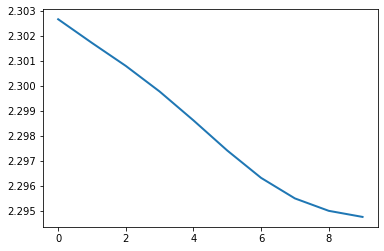

In [152]:
W1_t,b1_t,theta3_t,bias3_t,cost_t,accuracy_t = main_init(x_train[:500], y_train[:500] ,W1,b1,theta3,bias3)

plt.plot(cost_t, linewidth = 2)
plt.show()